In [1]:
import os
import sys

sys.path.append('/global/project/projectdirs/desi/users/mjwilson/repos/desispec/py/desispec/radlss/')

In [2]:
# import jax

In [3]:
os.environ['PYTHONPATH'] = '/global/homes/m/mjwilson/.local/lib/python3.8/site-packages/corner/:' + os.environ['PYTHONPATH']

In [4]:
import time
import glob
import scipy
import corner
import fitsio

import itertools
import warnings

import numpy as np
import pylab as pl

import desisim.templates
import astropy.io.fits              as      fits

import desispec.io
import redrock.templates
import matplotlib.pyplot            as      plt

from   os                           import  path
from   astropy.convolution          import  convolve, Box1DKernel
from   desispec.spectra             import  Spectra
from   desispec.frame               import  Frame
from   desispec.resolution          import  Resolution
from   desispec.io.meta             import  findfile
from   desispec.io                  import  read_frame, read_fiberflat, read_flux_calibration, read_sky, read_fibermap
from   desispec.interpolation       import  resample_flux
from   astropy.table                import  Table
from   desispec.io.image            import  read_image
from   specter.psf.gausshermite     import  GaussHermitePSF
from   scipy.signal                 import  medfilt
from   desispec.calibfinder         import  CalibFinder
from   astropy.utils.exceptions     import  AstropyWarning
from   scipy                        import  stats
from   pathlib                      import  Path
from   templateSNR                  import  templateSNR
from   RadLSS                       import  RadLSS
from   scipy.optimize               import  Bounds

In [5]:
# warnings.simplefilter('ignore', category=AstropyWarning)

# Foundations to desispec ticket 1004:  Template SNR and LSS rad. weights.

Template SNR:

https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=4723;filename=sky-monitor-mc-study-v1.pdf;version=2

applied to SV0 dataset:

https://desi.lbl.gov/trac/wiki/TargetSelectionWG/SV0

# Template SNR

$\Huge \langle tSNR^2 \rangle = \sum_{grz} \sum_{\lambda \in grz} \left ( \frac{\tau^2 T^2 \langle \Delta F^2 \rangle}{\sigma_e^2 \cdot {\rm NPIX/A} + \tau T_{\rm sky}  F_{\rm sky}} \right ) $

_"We choose to normalize it such that zSNR = 3 for a 1000 sec dark time exposure in
nominal conditions."_

Here:  
- $\sigma_e$ is the READNOISE in units of ELECTRONS / PIXEL. 
- NPIX/A is the projected fiber area in units of PIXELS for a width of **ONE ANGSTROM**.  
- $\Delta F$ is the residual (template) flux from a 100A filtered equivalent.
- $\tau$ is the exposure time, already included in the flux calib.
- $T_{\rm sky} F_{\rm sky}$ is the estimated fiber sky flux in units of ELECTRONS PER ANGSTROM.

In [6]:
def get_expids(night, andes='/global/cfs/cdirs/desi/spectro/redux/andes'):
    tiles  = np.unique(np.array([x.split('/')[-3] for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    # np.sort(np.array([x.split('/')[-1] for x in glob.glob(andes + '/exposures/{}/*'.format(night))]).astype(np.int))                                                                                  
    expids = np.unique(np.array([x.split('/')[-1].split('-')[2].replace('.fits','') for x in glob.glob(andes + '/tiles/*/{}/cframe-*'.format(night))]).astype(np.int))

    return  expids, tiles

In [7]:
nmax          = 1
night         = '20200315'
tracers       = ['ELG']

expids, tiles = get_expids(night)

cameras       = ['b5', 'r5', 'z5']

In [8]:
expids        = expids[1:2]

In [9]:
expids 

array([55589])

In [10]:
for nexp, expid in enumerate(expids):
    print('Solving for EXPID {:08d}'.format(expid))
    
    rads = RadLSS(night, expid, cameras=cameras)
    
    rads.compute(tracers=tracers, templates=False)

    if nexp == nmax:
        break

Solving for EXPID 00055589
Rank 0:  Grabbing camera b5
Rank 0:  Grabbing camera r5
Rank 0:  Grabbing camera z5
Rank 0:  Retrieved pipeline data in 0.095 mins.
Rank 0:  Successfully retrieved pre-written ensemble files at: /global/cscratch1/sd/mjwilson/radlss/test//ensemble/ (nmodel: 360)
Rank 0:  Grabbed deepfield ensemble (nmodel: 360) in 0.002 mins.


In [13]:
# ! ls /global/cscratch1/sd/mjwilson/radlss/test//ensemble/

In [15]:
# sample             = rads.ensemble_meta['ELG']['REDSHIFT', 'MAG_G', 'MAG_R', 'MAG_Z', 'OIIFLUX']
# sample['OIIFLUX'] *= 1.e17
# sample['r-z']      = sample['MAG_R'] - sample['MAG_Z'] 
# sample['g-r']      = sample['MAG_G'] - sample['MAG_R'] 

# del sample['MAG_G']
# del sample['MAG_R']
# del sample['MAG_Z']

# sample

In [17]:
# ndim, nsamples = 5, len(sample)

# data_kwargs    = {'markersize': 2, 'alpha': 1.0}

# figure         = corner.corner(np.array(np.array(sample).tolist()), labels=sample.dtype.names,
#                                quantiles=[0.16, 0.5, 0.84], plot_contours=False,
#                                show_titles=True, title_kwargs={"fontsize": 12},
#                                plot_datapoints=True, plot_density=False, no_fill_contours=True, data_kwargs=data_kwargs)

In [989]:
def oii(index, petal='5'):
    isin           = (rads.zbests[petal]['DELTACHI2'] > 80.) & (rads.zbests[petal]['Z'] > 0.8) & (rads.zbests[petal]['Z'] < 1.3)
        
    sample         = rads.zbests[petal][isin]

    oiia           = 3727.092 * (1. + sample[index]['Z'])
    oiib           = 3729.875 * (1. + sample[index]['Z'])
    
    if oiia > 7620.:
        arm        = 'z'
        
    else:
        arm        = 'r'
    
    cframe         = rads.cframes['{}{}'.format(arm, petal)][isin]
            
    rr             = rads.rr_cframes['{}{}'.format(arm, petal)].flux[isin][index,:]
    
    pl.plot(cframe.wave, cframe.flux[index,:])
    pl.plot(cframe.wave, convolve(cframe.flux[index,:], Box1DKernel(2. / 0.8), boundary='extend'))
    pl.plot(cframe.wave, rr)
    
    pl.axvline(oiia, c='k', alpha=0.4)
    pl.axvline(oiib, c='k', alpha=0.4)
    
    pl.title('z:  {:.2f}, oii:  {:.1f}A'.format(sample[index]['Z'], oiia))
    
    pl.xlim(oiia - 25., oiia + 25.)
    
    pl.ylim(-5., 5.)

In [990]:
# R      = Resolution(spectra.resolution_data['r'][i])
# txflux = R.dot(resample_flux(spectra.wave['r'], twave, tflux))

In [994]:
def doublet_model(z, sigma=10., r=0.1, linea=3727.092, lineb=3729.875, twave=np.arange(3100., 10400., 0.1)):
      '''
      See https://arxiv.org/pdf/2007.14484.pdf
      
      sigma:  velocity term, later convolved for resolution. 
      '''  

      lightspeed = 2.9979e5 # [km/s].      
      sigma      = sigma * (1. + z) * linea / lightspeed    
        
      # Unit amplitude, sigma is the width of the line, z is the redshift and r is the relative amplitudes of the lines in the doublet. 
      # [ergs/s/cm2/Angstrom].
        
      return  1. / (1. + r) / np.sqrt(2. * np.pi) / sigma * (r * np.exp(- ((twave - linea * (1. + z)) / np.sqrt(2.) / sigma)**2.) + np.exp(- ((twave - lineb * (1. + z)) / np.sqrt(2.) / sigma)**2.))

In [995]:
def line_fit(z, wave, Res, flux, continuum=0.0, sigma=5., r=0.1, line_flux=None, linea=3727.092, lineb=3729.875, twave=np.arange(3100., 10400., 0.1)):    
    tflux         = doublet_model(z=z, sigma=sigma, r=r, linea=linea, lineb=lineb, twave=twave)
    Rflux         = Res.dot(resample_flux(wave, twave, tflux))

    if line_flux == None:
      line_flux   = np.sum( flux * Rflux * ivar)
      line_flux  /= np.sum(Rflux * Rflux * ivar)
    
      line_flux_err = np.sum(Rflux * Rflux * ivar)
      line_flux_err = 1. / np.sqrt(line_flux_err)
 
    Rflux        *= line_flux
    # Rflux      += continuum

    X2            = np.sum((flux - Rflux)**2. * ivar)
    
    return  Rflux, X2, line_flux # line_flux_err

In [996]:
def X2(params, z, wave, Res, flux, continuum, linea, lineb, twave):
    [line_flux, r, sigma]               = params
    Rflux, X2, line_flux                = line_fit(z, wave, Res, flux, continuum, sigma, r, line_flux, linea, lineb, twave)
    
    return  X2

In [1205]:
index                               =  5
petal                               = '5'
band                                = 'r'
  
zz                                  = rads.zbests[petal]['Z'][index]
oii_truth                           = rads.ensemble_meta['ELG']['OIIFLUX'][index] 

wave                                = rads.cframes['{}5'.format(band)].wave
flux                                = rads.cframes['{}5'.format(band)].flux[index,:]
ivar                                = rads.cframes['{}5'.format(band)].ivar[index,:]

Res                                 = Resolution(rads.cframes['{}5'.format(band)].resolution_data[index])

zz                                  = rads.ensemble_meta['ELG']['REDSHIFT'][index]
flux                                = rads.ensemble_flux['ELG'][band][index]

twave                               = np.arange(3100., 10400., 0.1)

In [1207]:
window                              = np.arange((3727. * (1. + zz)) - 50., (3727. * (1. + zz)) + 50., 0.8)
xmin, xmax                          = window.min(), window.max()

continuum                           = ((wave > window.min()) & (wave < window.max())) & ((wave < (window.min() + 20.)) | (wave > (window.max() - 20.)))
continuum                           = np.median(flux[continuum])

In [1208]:
flux                                = np.array(flux, copy=True)
flux                               -= continuum

In [1209]:
args                                = (zz, wave, Res, flux, 0.0, 3727.092, 3729.875, twave)

In [1210]:
linea                               = 3727.092
lineb                               = 3729.875

In [1211]:
bounds                              = Bounds([0.0, 0.0, 0.0], [50., 1.0, 100.])

In [1222]:
x0                                  = np.array([28., 0.7, 30.])
result                              = scipy.optimize.minimize(X2, x0, args, method='CG')

[line_flux, r, sigma]               = result.x

TypeError: X2() takes 1 positional argument but 9 were given

In [1103]:
line_flux, r, sigma

(29.295299938070418, 0.8399221293192556, 74.82173195275278)

In [1104]:
Rflux, _, _                         = line_fit(zz, wave, Res, flux, sigma=sigma, r=r, line_flux=line_flux)

(5989.275494456291, 6088.475494456314)

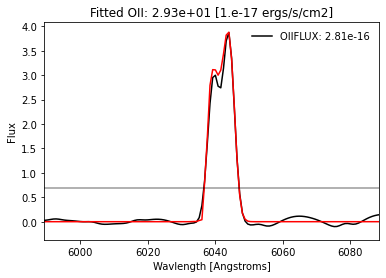

In [1108]:
pl.plot(wave, flux,  c='k', label='OIIFLUX: {:.2e}'.format(oii_truth))
pl.plot(wave, Rflux, c='r')

pl.axhline(continuum, alpha=0.4, c='k')

pl.legend(frameon=False)

pl.title('Fitted OII: {:.2e} [1.e-17 ergs/s/cm2]'.format(line_flux))

pl.xlabel('Wavlength [Angstroms]')
pl.ylabel('Flux')

pl.xlim(xmin, xmax)

In [1109]:
result

     fun: 312.28049599663206
     jac: array([-2.28881836e-05,  5.72204590e-05,  3.43322754e-05])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 725
     nit: 50
    njev: 179
  status: 2
 success: False
       x: array([29.29529994,  0.83992213, 74.82173195])

In [1213]:
import jax.numpy      as     jnp
 
from   jax            import hessian, grad
from   scipy.stats    import multivariate_normal
from   scipy.optimize import minimize

In [1214]:
sigma     = jnp.array([(1.0, 0.5), (0.5, 1.0)])
mu        = jnp.array([0.5, 2.0])
nu        = jnp.array([7])

sigma_inv = jnp.linalg.inv(sigma)

In [1215]:
def negative_log_posterior(theta):
    return (-jnp.log(
        1.0 + nu ** -1.0 * jnp.dot((theta - mu), jnp.dot(sigma_inv, (theta - mu).T).T)
    ) * (0.5  * -(nu + theta.shape[0])))[0]

In [1216]:
def grad_negative_log_posterior(theta):
    return grad(negative_log_posterior)(theta)

In [1217]:
def approx_covariance_matrix(theta):
    return jnp.linalg.inv(hessian(negative_log_posterior)(theta))

In [1219]:
theta_star = minimize(
    negative_log_posterior, 
    jnp.array([0.0, 0.0]), 
    jac=grad_negative_log_posterior, 
    method="BFGS"
).x

In [1220]:
theta_star

array([0.49996502, 2.0000122 ])

In [1223]:
sigma_approx = sigma_approx = approx_covariance_matrix(theta_star)
sigma_approx

DeviceArray([[0.77777773, 0.38888887],
             [0.38888887, 0.77777773]], dtype=float32)

In [1225]:
mu

DeviceArray([0.5, 2. ], dtype=float32)

In [1224]:
sigma

DeviceArray([[1. , 0.5],
             [0.5, 1. ]], dtype=float32)

# Done.